# Simulación LegPy de una fuente de braquiterapia
-----
En este cuaderno se estudia la distribución de dosis generada por una semilla para implantes permanentes en la próstata.

La distribución de dosis se genera por simulación Montecarlo utilizando LegPy.

## Fuente simulada

La fuente que se simulará será la **semilla Bebig I25.S06**.

## Ejecución del cuaderno

El cuaderno proporciona todas las herramientas para realizar la simulación y su validación. Sólo es necesario introducir los valores del espectro del elemento radiactivo contenido en la fuente y su longitud.

## Validación de los resultados

Para validar la simulación se compara la distribución de dosis calculada con la derivada del formalismo de TG43 AAPM que se ha presentado en clase. La documentación del formalismo se puede consultar en el siguiente enlace

https://aapm.onlinelibrary.wiley.com/doi/epdf/10.1118/1.1646040

#### Formalismo

Dada una fuente y tomando un sistema de coordenadas como el descrito en el siguiente esquema

<img src="https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/EsquemaCoordenadas.png" alt="Coor definition" width="40%">

la distribución espacial de la dosis se puede describir según dos aproximaciones


**Aproximación 2D**

\begin{equation}
    \dot D(r, \theta) = S_K \Lambda \frac{G_L(r, \theta)}{G_L(r_0, \theta_0)}g_L(r)F(r, \theta)
\end{equation}

en la que se tiene en cuenta la variación angular de la distribución de dosis alrededor de la fuente $\theta$ y la distancia a su centro $r$.

**Aproximación 1D, distribución isótropa, fuente puntual**
\begin{equation}
    \dot D(r) = S_K \Lambda \frac{G_L(r, \theta_0)}{G_L(r_0, \theta_0)}g_L(r)\phi_{an}(r)
\end{equation}

en la que la distribución de dosis se promedia angularmente y solo aparece la dependencia con la distancia al centro de la fuente $r$.

En ambas aproximaciones
\begin{equation}
G_L(r, \theta)= \left\{ \begin{array}{lcc}
                             \frac{\beta}{Lr\sin(\theta)} & \text{si} & \theta \neq 0 \\
                             \frac{1}{r^2-L^2/4} & \text{si} & \theta = 0
                         \end{array}
               \right.
\end{equation}

Para poder calcular la distribución de tasa de dosis tenemos que calcular $\beta$ en función de $r$ y $\theta$, $\beta = \beta(r, \theta)$.

Por construcción de triángulos es inmediato ver que $\beta = \theta_2 - \theta_1$ y que se verifican las ecuaciones

\begin{equation}
    \theta_1 = \arctan\left( \frac{r \sin (\theta)}{r \cos (\theta) + L/2} \right)
\end{equation}

\begin{equation}
\theta_2 = \left\{ \begin{array}{lcc}
                       \arctan \left(\frac{r \sin(\theta)}{r \cos(\theta)-L/2}\right) & \text{si} & r \cos(\theta) > L/2 \\
                       \pi/2 & \text{si} & r \cos(\theta) = L/2 \\
                       \pi/2 + \arctan \left(\frac{L/2 + r \cos(\theta)}{r \sin(\theta)}\right) & \text{si} & r \cos(\theta) < L/2
                   \end{array}
           \right.
\end{equation}

De donde obtendríamos $\beta = \beta(r, \theta)$

### Convenio de unidades
- longitudes en cm
- ángulos en grados sexagesimales
- Energía en MeV

Constante con la longitud efectiva de la fuente. Utilizar la $L$ de la aproximación lineal. Ver la Tabla II del TG43.

In [2]:
L = 0.35 ##- Introducir el valor de la longitud de la fuente - ##

Constantes con las coordendas del punto de referencia

In [3]:
r0, theta0 = 1, 90


## Montar gDrive

Para acceder a los archivos almacenados en nuestro Google Drive desde cuadernos Colab primero es necesario montar el disco.

El siguiente código realiza ese proceso. Para completarlo Colab nos pedira autorización para acceder a nuestro disco

In [4]:
# - Importar el módulo para acceder a Drive
from google.colab import drive
# - Montar el disco
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Instalación de LegPy

Clonamos el repositorio de LegPy en la carpeta content de Colab

In [5]:
!git clone https://github.com/JaimeRosado/LegPy

Cloning into 'LegPy'...
remote: Enumerating objects: 1110, done.
remote: Counting objects: 100% (561/561), done.
remote: Compressing objects: 100% (503/503), done.
remote: Total 1110 (delta 137), reused 465 (delta 57), pack-reused 549 (from 1)
Receiving objects: 100% (1110/1110), 2.75 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (293/293), done.


Añadimos la carpeta de LegPy a las rutas en las que el sistema busca módulos de python

In [6]:
import sys
sys.path.append('/content/LegPy')

Cambiamos al directorio de trabajo

In [8]:
#- Seleccionar la carpeta de gDrive en la que queramos hacer el análisis y cambiar el directorio de trabajo a ella.
import sys
sys.path.insert(0,'/content/LegPy')
 ###Sustitir aquí la ruta a la carpeta seleccionada para trabajar en ella###

Importamos los módulos y funciones que utilizaremos en este cuaderno

In [9]:
import LegPy as lpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d, RectBivariateSpline

Definimos la constante de conversion entre grados sexagasimales a radianes

In [10]:
d_r = np.pi/180

### Definir el medio y la geometría

In [11]:
# tamaño del medio (cilindro)
length = 14. # cm
width = 14. # cm diametro
nz, nr = 112, 56 # intervalos en z y r
medium = lpy.Medium(name='Water, Liquid')
geometry = lpy.Geometry(name='cylinder', z = length, r = width/2., n_z = nz, n_r = nr) # Cylindrical voxelization

### Espectro de energía de la fuente

Definir el espectro del isótopo radiactivo de la semilla. Utilizar los datos recomendados por el TG43. Ver la Tabla XIII.

La manera de definir el espectro es mediante el código

```
E = np.array([[Energía del fotón 1, Número de fotones 1 por desintegracion],  [Energía del fotón 2, Número de fotones 2 por desintegracion], ...])

spectrum = lpy.Spectrum(name = 'multi_mono', E_w = E)
```


In [12]:
## Introducir la definición del espectro de la simulación - ##
import numpy as np

E = np.array([[27.202e-3, 0.0028], [27.472e-3, 0.1430], [31.012e-3, 0.0022], [31.428e-3, 0.8370], [35.492e-3, 0.0660]])
spectrum = lpy.Spectrum(name='multi_mono', E_w=E)


### Geometría de la fuente

In [13]:
x, y, z = 0., 0., 7. # cm posición del centro de la fuente
s_length = 0.45 # cm longitud de la semilla
s_width = 0.05 # cm radio de la semilla
beam = lpy.Beam(name = 'isotropic', p_in = np.array ([x, y, z]))

### Visualizar algunas trazas

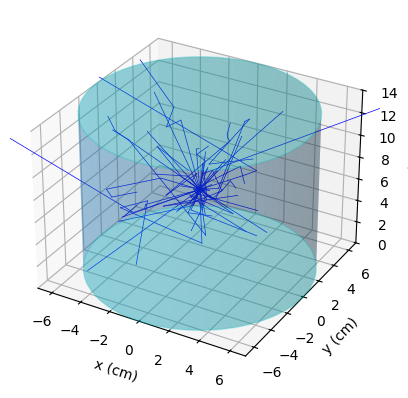

In [14]:
lpy.Plot_beam(medium, geometry, spectrum, beam)

### Realizar la simulación

En las máquinas de Google Colab la simulación requiere unos cuarenta minutos para 10 millones de fotones emitidos.

El número considerado es adecuado para tener una estadística razonable para poder validar la simulación.

In [15]:
n_ph = int(1.e7) # números de fotones a simular
output = lpy.MC(medium, geometry, spectrum, beam, n_part = n_ph, E_cut = 0.001)


The simulation has ended

Computing time per beam particle =  2.61e-04 seconds



### Resultado de la simulación

In [16]:
# Usamos el dataFrame generado en la simulación
Ddf = output.Edep_to_df()

Guardamos los resultados de la simulación en un archivo Excel para evitar tener que esperar el tiempo de cálculo de nuevo.

In [17]:
Ddf.to_excel('BebigSimulation_1e7photons.xlsx')

Para recuparar los resultados correr el código

`Ddf = pd.read_excel('BebigSimulation_1e7photons.xlsx', index_col='z(cm)')`


Obtenemos las coordenadas y los valores de deposito de energía.

Seleccionar el deposito de energía en función de la distancia radial en el plano perpedicular a la fuente y que la bisecciona.

In [18]:
X = np.array(Ddf.columns)
Y = np.array(Ddf.index)
Z = Ddf.to_numpy()
Dr = Z[55]

Obtener el factor de normalización del depósito de dosis. De acuerdo al formalismo de la AAPM se normaliza a un 1 cm de la fuente. Las coordenadas más próximas a 1 son

In [19]:
X[7], X[8]

(np.float64(0.9375), np.float64(1.0625))

Interpolamos para X = 1 cm

In [20]:
Drn = Dr[7] + (Dr[8] - Dr[7])/(X[8] - X[7])*(1.-X[7])

### Cálculos TG43 para la fuente Bebig de I125

Leemos los datos tabulados de la AAPM

Función de dosis radial $g_L$, función de anisotropía $\phi_{an}(r)$ para la aproximación 1D y función $F(r, \theta)$ para el tratamiento 2D

In [21]:
# Descargar los datos tabulados de la fuente
!wget -O FuncionesDosimetricas.xlsx https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/FuncionesDosimetricas.xlsx

--2025-05-11 18:31:03--  https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/FuenteBraquiterapia/FuncionesDosimetricas.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11320 (11K) [application/octet-stream]
Saving to: ‘FuncionesDosimetricas.xlsx’

FuncionesDosimetric 100%[===================>]  11.05K  --.-KB/s    in 0s      

2025-05-11 18:31:03 (41.5 MB/s) - ‘FuncionesDosimetricas.xlsx’ saved [11320/11320]



Cargamos las tablas de la AAPM

In [22]:
gdf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='g')
phiandf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='phi_an')
Fdf = pd.read_excel('FuncionesDosimetricas.xlsx', sheet_name='F')

## Implementación continua de las tablas de la AAPM
El código definido en esta sección implementa funciones que leen los datos de las tablas de la AAPM y mediante interpolación permiten generar datos continuos en el espacio.

### Definición de las funciones $\beta(r, \theta)$, $G_L(r, \theta)$, $g_L(r)$, $F(r, \theta)$ y  $\phi_{an}(r)$
Todas estas funciones se vectorizan. Recordemos que a una función que soporta vectorización se le puede pasar un array y la función se aplicará sobre cada elemento del array sin necesidad de iterar. Por tanto una función vectorizada devuelve un array de las mismas dimensiones que el array de entrada.

In [23]:
### - Este código no se tiene que modificar - ###

# Definir la función beta
def beta(r, theta):
    if r * np.cos(theta) > L/2:
        return np.arctan(r*np.sin(theta)/(r*np.cos(theta)-L/2)) - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2))
    elif r * np.cos(theta) == L/2:
        return np.pi/2 - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2))
    else:
        return (np.pi/2 + np.arctan((L/2-r*np.cos(theta))/r/np.sin(theta))
                - np.arctan(r*np.sin(theta)/(r*np.cos(theta)+L/2)))

# Definir la función G_L
def G_L(r, theta):
    if theta == 0:
        return 1 / (r**2 - L**2/4)
    else:
        return beta(r, theta)/(L * r * np.sin(theta))
# Vectorizarla
G_L_v = np.vectorize(G_L)

# Definir la función g_L
def g_L(r):
    return gdf.loc[gdf['r']==r]['Lineal'].values[0]
# Vectorizarla
g_L_v = np.vectorize(g_L)

# Definir la función de anisotropia 1D
def phi_an(r):
    return phiandf.loc[phiandf['r']==r]['phi'].values[0]
# Vectorizarla
phi_an_v = np.vectorize(phi_an)

# Definir la función de anisotropia 2D
def F(r, theta):
    theta = abs(theta)
    return Fdf.loc[Fdf['theta']==theta][r].values[0]
# Vectorizarla
F_v = np.vectorize(F)

Definimos la constante de normalización de la función de geometría $G_L(r_0, \theta_0)$

In [24]:
G_L_r0_theta0 = G_L(r0, theta0 * d_r)

Para generar el gráfico con la distribución espacial de la tasa de dosis en una geometría similar a la de la simulación definimos los vectores con el muestreo de $r$ y $\theta$

In [25]:
### - Este código no se tiene que modificar - ###
rv = np.array([0.25, 0.5, 1., 2., 3.,  4., 5., 7.])
thetav = Fdf['theta'].values

Generamos los mallados de coordenadas

In [26]:
### - Este código no se tiene que modificar - ###
R, Theta = np.meshgrid(rv, thetav * d_r) # Ángulos en radianes
R, ThetaDeg = np.meshgrid(rv, thetav)    # Ángulos en grados sexagesimales

Definimos las funciones de interpolación para las funciones $g_L$, $F$ y  $\phi_{an}$ y las vectorizamos

In [27]:
### - Este código no se tiene que modificar - ###
%%capture --no-display

# Definir funciones
g_Lf = interp1d(rv, g_L_v(rv), kind='cubic', bounds_error=False, fill_value="extrapolate")
Ff = RectBivariateSpline(R[0,:], ThetaDeg[:,0], np.transpose(F_v(R, ThetaDeg)))
phi_anf = interp1d(rv, phi_an_v(rv), kind='cubic', bounds_error=False, fill_value="extrapolate")

# Vectorizarlas
Ffv = np.vectorize(Ff)
phi_anfv = np.vectorize(phi_anf)

### Comparación con las aproximaciones 1D y 2D del TG43

### Curvas de isovalores, igual tasa de dosis

Comparamos la distribución calculada utilizando LegPy con la aproximación 1D de la AAPM.

Calculamos primero un valor de renormalización igualando el valor de ambas distribuciones en el punto de referencia

In [28]:
def norm_val(S, Phi, Dr):
    Drn = Dr[7] + (Dr[8] - Dr[7])/(X[8] - X[7])*(1.-X[7])
    return G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * phi_anfv(S)/Drn

knorm = norm_val(1, 0, Dr)

Comparación con la aproximación 1D

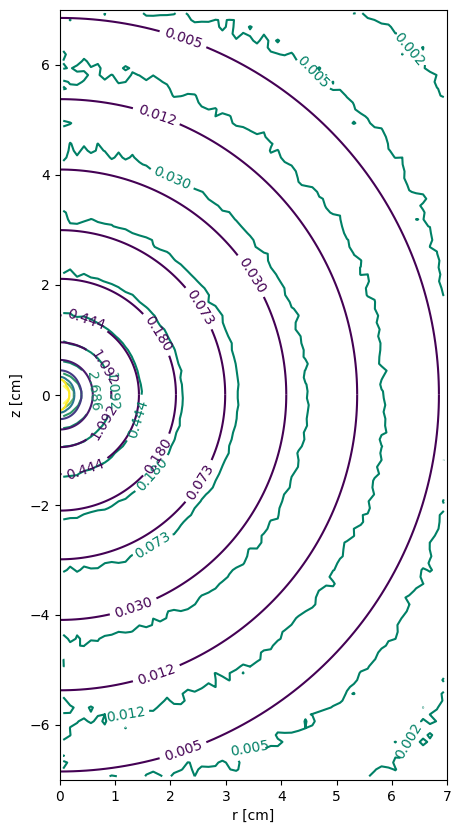

In [29]:
%%capture --no-display
# Aproximación 1D
# Vectores con las coordenadas radial 's' y angular 'phi'
sv, phiv = np.arange(0, 7.05, 0.1), np.arange(0.0, 90.05, 1)
# Establecer el mallado de coordenandas necesario para la representación 2D
# Coordenadas polares
S, Phi = np.meshgrid(sv, phiv)
# Coordenadas cartesianas
U, V = S * np.sin(Phi*d_r), S * np.cos(Phi*d_r)
# Cálculo de la aproximación 1D
D_rate_den_1D = G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * phi_anfv(S)
# Construir la figura
fig, ax = plt.subplots(figsize=(5, 10))
# Definir los niveles de las isodosis
levels = np.geomspace(0.002, 40., 12)
# Representar la simulación realizada por LegPy, recentrándola para colocar la fuente en el origen
CSL = ax.contour(X, Y - 7, knorm * Z, levels=levels, cmap='summer')
ax.clabel(CSL, levels, fmt='%4.3f')
# Representar la aproximación 1D
CS1D = ax.contour(U, V, D_rate_den_1D, levels=levels, cmap='viridis')
ax.clabel(CS1D, levels, fmt='%4.3f')
CS1D = ax.contour(U, -V, D_rate_den_1D, levels=levels, cmap='viridis')
ax.clabel(CS1D, levels, fmt='%4.3f')
# Formato de los ejes
ax.set_xlabel('r [cm]')
ax.set_ylabel('z [cm]')
plt.show()

Comparación con la aproximación 2D

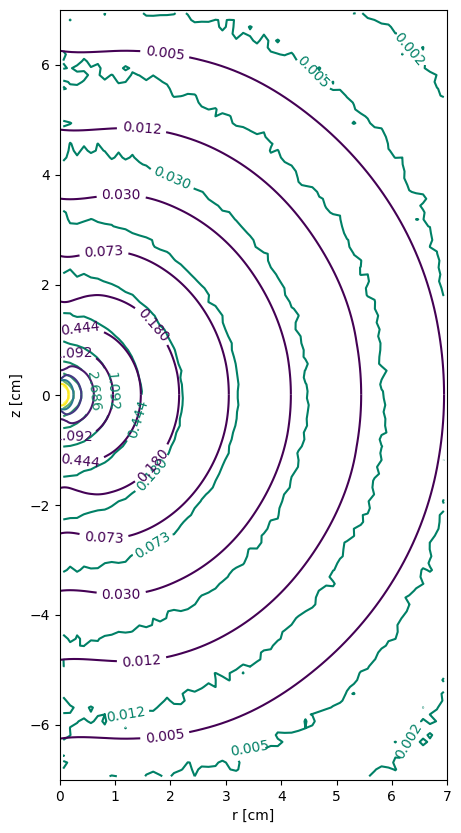

In [30]:
%%capture --no-display
# Aproximación 2D
# Vectores con las coordenadas radial 's' y angular 'phi'
sv, phiv = np.arange(0, 7.05, 0.1), np.arange(-0.0, 90.05, 1)
# Establecer el mallado de coordenandas necesario para la representación 2D
# Coordenadas polares
S, Phi = np.meshgrid(sv, phiv)
# Coordenadas cartesianas
U, V = S * np.sin(Phi*d_r), S * np.cos(Phi*d_r)
# Cálculo de la aproximación 2D
D_rate_den_2D = G_L_v(S, Phi*d_r) / G_L_r0_theta0 * g_Lf(S) * Ffv(S, Phi)
# Construir la figura
fig, ax = plt.subplots(figsize=(5, 10))
# Definir los niveles de las isodosis
levels = np.geomspace(0.002, 40., 12)
# Representar la simulación realizada por LegPy
CSL = ax.contour(X, Y - 7, Z * knorm, levels=levels, cmap='summer')
ax.clabel(CSL, levels, fmt='%4.3f')
# Representar la aproximación 2D
CS2D = ax.contour(U, V, D_rate_den_2D, levels=levels)
ax.clabel(CS2D, levels, fmt='%4.3f')
CS2D = ax.contour(U, -V, D_rate_den_2D, levels=levels)
ax.clabel(CS2D, levels, fmt='%4.3f')
# Formato de los ejes
ax.set_xlabel('r [cm]')
ax.set_ylabel('z [cm]')
ax.set_xlim(0, 7)
ax.set_ylim(-7, 7)
plt.show()

### Validación a través de la función de dosis radial

Calculamos la función $g_L(r)$ a partir del depósito relativo de energía
\begin{equation}
  g_L(r) = \frac{\dot D(r)}{\dot D(r_0)}\frac{G_L(r_0, \theta_0)}{G_L(r, \theta_0)}
\end{equation}

Donde hemos tenido en cuenta que en la aproximación 2D $F(r, \theta_0) = 1$

Hacemos una gráfica en la que comparamos la función $g_L$ tabulada según las dos aproximaciones con los datos obetenidos de la simulación

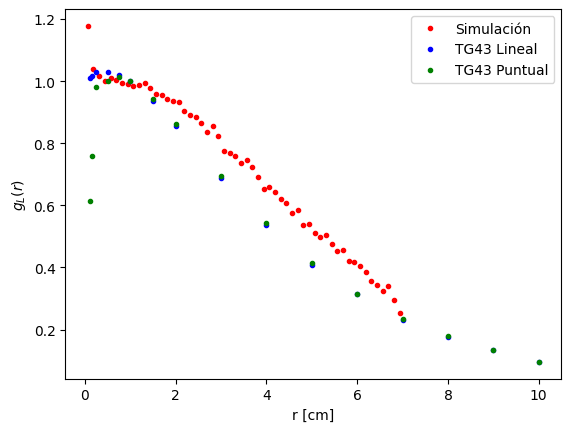

In [31]:
fig, ax = plt.subplots()
ax.plot(X, Dr/Drn * G_L_r0_theta0/G_L_v(X, 90*d_r), 'r.')
ax.plot(gdf.r, gdf.Lineal, 'b.')
ax.plot(gdf.r, gdf.Puntual, 'g.')

ax.set_xlabel('r [cm]')
ax.set_ylabel('$g_L(r)$')

ax.legend(['Simulación', 'TG43 Lineal', 'TG43 Puntual'])
plt.show()

## Cuestiones

Comentar los resultados obtenidos respondiendo las siguientes preguntas

- *¿Cuál de las dos aproximaciones parece más adecuada para describir la fuente?*

Por las imágenes obtenidas se podría concluir que el caso de la aproximación 1D o puntual. En el caso 2D los valores de la simulación quedan bastante más alejados de los resultantes de la aproximación, especialmente para los valores de r entre 0 y 1 cm, donde la simulación se aleja mucho más que para el caso 1D.

De cualquier manera, en ambos casos la simulación es peor según la distancia con la semilla aumenta.  
- *A la vista de los resultados ¿hay un proceso físico que no se esté teniendo en cuenta en la simulación de la fuente? ¿Por qué es diferente el grado de acuerdo en el eje que contiene la fuente al de la dirección perpendicular?*

La dispersión de fotones por el material de contención de la semilla no se ha tenido en cuenta, ya que en la simulación se ha realizado suuponiendo que la semilla estaba directamente al aire. En el caso 2D esto se aprecia mejor, ya que no se parte desde el centro de la semilla, por lo que los fotones pueden atravesar mayor cantidad de material de contención, lo que reduce más la dosis. Y esto es lo que podría explicar lo que se mencionó en la pregunta anterior de la especial atenuación para los valores de r entre 0 y 1 cm.

Respecto al grado de acuerdo en el eje de la fuente y el de la dirección perpendicular, tiene valores distintos para cada uno. Esto es porque al no ser esférica la semilla. Esto hace que la emisión en el eje de la fuente sea como una emisión radial, sin embargo en el eje perpendicular no. Por lo tanto, es principalmente debido a la geometría de la semilla.

- *Desde un punto de vista cualitativo ¿cuánto de importante es haber ignorado en la simulación el material de contención del material radiactivo?*

Al no tener en cuenta este material de contención, el cálculo que se hace de la dosis en el entorno más cercano a las semillas es superior al que realmente es. Por lo tanto es posible que parte del tejido tumoral no reciba suficiente dosis y el tratamiento no esté siendo tal como se prevee.
- *Sabiendo que el volumen típico de la próstata es de unos 75 centímetros cúbicos y que en un implante se intenta colocar las semillas en un mallado cúbico separadas unas de otras por un un centímetro, realizar una estimación de la incertidumbre en el cálculo de dosis por emplear la aproximación 1D frente a la 2D. (Basta con dar una explicación cualitativa de cómo se haría la estimación)*

Las semillas se colocan en una grilla cúbica, que al ser en un volumen de 75 centímetros cúbicos, se situarán aproximadamente 75 semillas en todas las posiciones posibles. Esto lleva a una superposición de dosis, ya que muchos puntos de este volumen reciben contribuciones de varias semillas. Pero para el caso 1D, aunque simplifica la emisión, y cerca de la semilla se sobreestime la dosis y en el eje perpendicular pueda haber subestimación, al haber tantas semillas, los errores individuales se pueden ver compensados. Además, diversos estudios y recomendaciones clínicas indican que el uso de la aproximación 1D crea unos errores entorno al 5-10 %, en las regiones periféricas, lo cual es una estimación muy aceptada.

En el caso de 2D, a pesar de ser un modelo más realista, la anisotropía hace que la dosis cerca del eje longitudinal sea menor, esto hace que a la hora de considerar la malla completa, haya ciertas "penalizaciones" en el valor de la dosis. Siendo así un modelo menos homegeneamente distribuido, calcula una dosis global menor que 1D, dando así una incertidumbre mayor en el cálculo de la dosis.